## FAO data for crop as percent of crop group
To be used to weight lamda when a commodity is not specific (e.g. Vegetable seed; Tomato seed out of vegetable seed ~ Tomatoes out of vegetables)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Access the fao data (downloaded from: https://www.fao.org/faostat/en/#data/QCL)
drive_letter = "Q:"
dir = f"{drive_letter}\Shared drives\APHIS  Projects\Pandemic\Data\FAOSTAT"

crop_groups = pd.read_csv(f'{dir}\FAOSTAT_data_item_group.csv',  encoding = "ISO-8859-1")
crops = pd.read_csv(f'{dir}\Production_Crops_Livestock_E\Production_Crops_Livestock_E_All_Data_NOFLAG.csv',  encoding = "ISO-8859-1")
crosswalk = pd.read_csv(f'{dir}\FAOSTAT_countries.csv', usecols=['Country Code','Country','ISO3 Code']).drop_duplicates()

In [3]:
# Add ISO3 code to crops

crops = pd.merge(crops, crosswalk, how="left", left_on="Area Code", right_on="Country Code")

In [4]:
print("Available groups of crops within FAO data:\n")
for i in crop_groups['Item Group'].unique(): print(i)

Available groups of crops within FAO data:

Beef and Buffalo Meat
Butter and Ghee
Cattle and Buffaloes
Cereals, Total
Cheese (All Kinds)
Citrus Fruit, Total
Crops Primary
Crops Processed
Eggs Primary
Evaporat&Condensed Milk
Fibre Crops Primary
Fruit Primary
Hides and skins, primary
Live Animals
Livestock primary
Livestock processed
Meat, Poultry
Meat, Total
Milk, Total
Oilcrops
Oilcrops, Cake Equivalent
Oilcrops, Oil Equivalent
Poultry Birds
Pulses, Total
Roots and Tubers, Total
Sheep and Goat Meat
Sheep and Goats
Skim Milk&Buttermilk,Dry
Sugar Crops Primary
Treenuts, Total
Vegetables Primary


In [5]:
print("Available crops within FAO data:\n")
for i in crops['Item'].unique(): print(i)

Available crops within FAO data:

Almonds, with shell
Anise, badian, fennel, coriander
Apples
Apricots
Asses
Barley
Berries nes
Butter and ghee, sheep milk
Butter, cow milk
Camels
Cattle
Cheese, goat milk
Cheese, sheep milk
Chickens
Cotton lint
Cottonseed
Eggs, hen, in shell
Eggs, hen, in shell (number)
Fat, camels
Fat, cattle
Fat, goats
Fat, sheep
Figs
Fruit, citrus nes
Fruit, fresh nes
Fruit, stone nes
Goats
Grapes
Hides, cattle, fresh
Honey, natural
Horses
Linseed
Maize
Meat, camel
Meat, cattle
Meat, chicken
Meat, game
Meat, goat
Meat, sheep
Melons, other (inc.cantaloupes)
Milk, skimmed cow
Milk, whole fresh camel
Milk, whole fresh cow
Milk, whole fresh goat
Milk, whole fresh sheep
Millet
Molasses
Mules
Nuts nes
Offals, edible, camels
Offals, edible, cattle
Offals, edible, goats
Offals, sheep,edible
Oil, cottonseed
Oil, linseed
Oil, olive, virgin
Oil, sesame
Oil, sunflower
Olives
Onions, dry
Oranges
Peaches and nectarines
Pears
Pistachios
Plums and sloes
Potatoes
Pulses nes
Rice, pa

In [6]:
# Crops considered vegetables (for exploratory analysis)

vegetables = crop_groups.loc[crop_groups['Item Group']=="Vegetables Primary","Item"].values
print(vegetables)

['Artichokes' 'Asparagus' 'Beans, green' 'Cabbages and other brassicas'
 'Carrots and turnips' 'Cassava leaves' 'Cauliflowers and broccoli'
 'Chillies and peppers, green' 'Cucumbers and gherkins'
 'Eggplants (aubergines)' 'Garlic' 'Leeks, other alliaceous vegetables'
 'Lettuce and chicory' 'Maize, green' 'Mushrooms and truffles' 'Okra'
 'Onions, dry' 'Onions, shallots, green' 'Peas, green'
 'Pumpkins, squash and gourds' 'Spinach' 'String beans' 'Tomatoes'
 'Vegetables, fresh nes' 'Vegetables, leguminous nes']


In [7]:
# Reformatting to long format

crops_long = pd.wide_to_long(crops.reset_index(), i="index", stubnames="Y", j="Year")

crops_long.reset_index(inplace=True)
crops_long.rename(columns={'Y':'Value'}, inplace=True)


In [8]:
crops_long

,index,Year,Area,Item,Country Code,Item Code,Unit,Area Code,Country,ISO3 Code,Element,Element Code,Value
0,0,1961,Afghanistan,"Almonds, with shell",2.0,221,ha,2,Afghanistan,AFG,Area harvested,5312,NaN
1,1,1961,Afghanistan,"Almonds, with shell",2.0,221,hg/ha,2,Afghanistan,AFG,Yield,5419,NaN
2,2,1961,Afghanistan,"Almonds, with shell",2.0,221,tonnes,2,Afghanistan,AFG,Production,5510,NaN
3,3,1961,Afghanistan,"Anise, badian, fennel, coriander",2.0,711,ha,2,Afghanistan,AFG,Area harvested,5312,NaN
4,4,1961,Afghanistan,"Anise, badian, fennel, coriander",2.0,711,hg/ha,2,Afghanistan,AFG,Yield,5419,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4632321,78509,2019,Net Food Importing Developing Countries,"Treenuts, Total",NaN,1729,hg/ha,5817,NaN,NaN,Yield,5419,5333.0
4632322,78510,2019,Net Food Importing Developing Countries,"Treenuts, Total",NaN,1729,tonnes,5817,NaN,NaN,Production,5510,2709134.0
4632323,78511,2019,Net Food Importing Developing Countries,Vegetables Primary,NaN,1735,ha,5817,NaN,NaN,Area harvested,5312,7519922.0
4632324,78512,2019,Net Food Importing Developing Countries,Vegetables Primary,NaN,1735,hg/ha,5817,NaN,NaN,Yield,5419,117384.0


In [9]:
# Dropping 2020 due to potential for missing (recent) and/or anamolous (COVID) data

crops_long = crops_long.loc[(crops_long['Year'] < 2020) & (crops_long['Year'] > 2000)]


In [10]:
# Keep Area harvested as metric of interest

crops_long = crops_long.loc[(crops_long['Element']=="Area harvested") & crops_long['Value'].notna()]

In [11]:
# Any relevant missing country codes?

crops_long.loc[crops_long['ISO3 Code'].isna(), 'Country'].unique()

array(['China, mainland', 'Sudan (former)', nan], dtype=object)

In [12]:
# Including two missing ISO3 codes

crops_long.loc[crops_long['Country']=='China, mainland', 'ISO3 Code'] = 'CHN'
crops_long.loc[crops_long['Country']=='Sudan (former)', 'ISO3 Code'] = 'SDN'

In [13]:
# Dealing with non-country areas

crops_long.loc[crops_long['ISO3 Code'].isna(),'Area'].unique()

# All are regions? 
# Australia and New Zealand are already each captured separately

array(['World', 'Africa', 'Eastern Africa', 'Middle Africa',
       'Northern Africa', 'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia and New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'European Union (28)',
       'European Union (27)', 'Least Developed Countries',
       'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries'], dtype=object)

In [14]:
# Drop regions

crops_long = crops_long.loc[crops_long['ISO3 Code'].notna()]

In [15]:
# Write to CSV

crops_long.to_csv(f'FAOSTAT_crop_area_by_ISO3.csv')

## Looking at the data for tomatoes

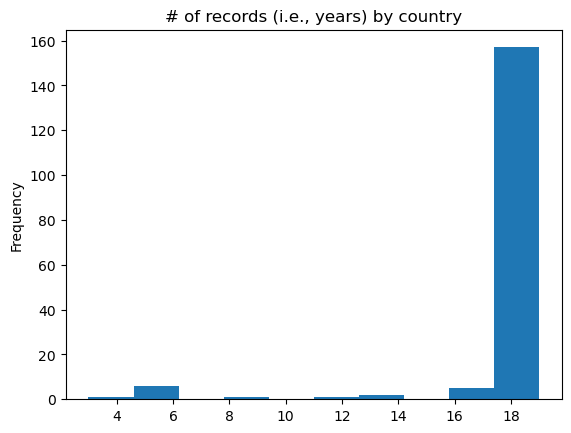

Data about tomatoes is available for 173 countries.


In [16]:
# Mostly complete records, but there are several countries with fewer records (and this is just one example crop)

veg_harvest = crops_long.loc[crops_long['Item'].isin(vegetables)]
veg_harvest.loc[veg_harvest['Item']=='Tomatoes'].groupby('Area').aggregate('count').sort_values('Value')['Value'].plot.hist()
plt.title("# of records (i.e., years) by country")
plt.show()

print(f"Data about tomatoes is available for {len(veg_harvest.loc[veg_harvest['Item']=='Tomatoes'].groupby('Area').aggregate('count').index)} countries.")

## Individual country reports over time

In [18]:
def plot_crop(country, crop):
    veg_harvest.loc[(veg_harvest['Item']==crop) & (veg_harvest['Area'] == country),['Year','Value']].plot(x='Year',y='Value', legend=None)
    plt.title(f"Country: {country}, Crop: {crop}")
    plt.show()

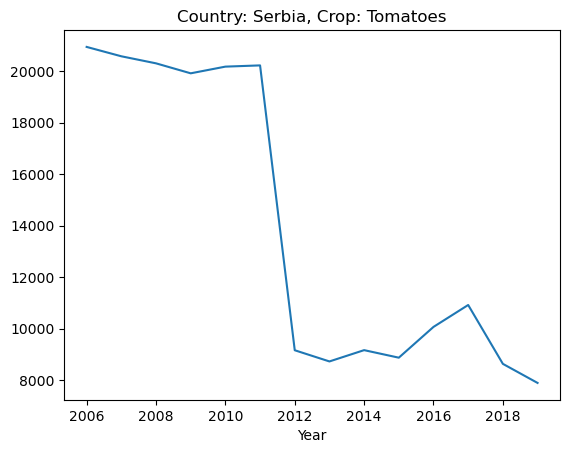

In [19]:
plot_crop("Serbia","Tomatoes")

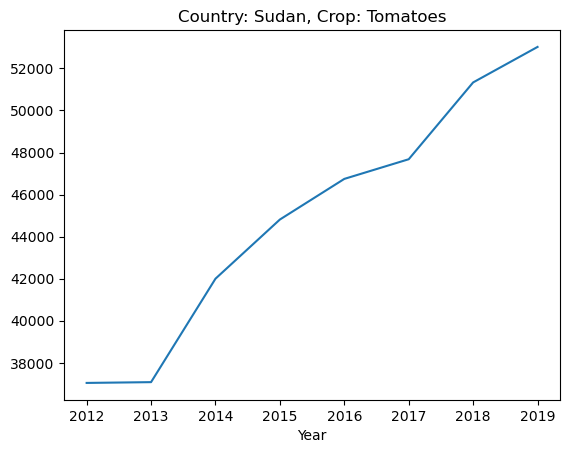

In [20]:
plot_crop("Sudan","Tomatoes")

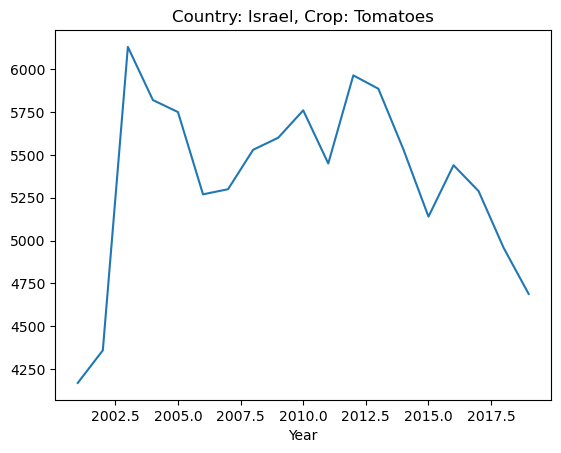

In [21]:
plot_crop("Israel","Tomatoes")

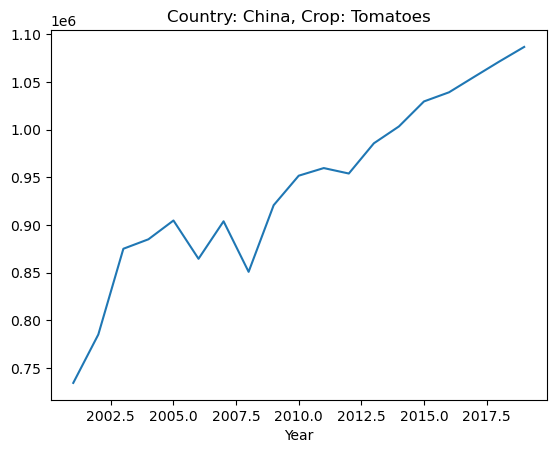

In [22]:
plot_crop("China","Tomatoes")

## Function to create data input for model

Complete: 

- Final data format
- Select a crop or list of crops
- Calculate % of total area (mean of the most recent 'x' years)
- Map country names to Pandemic shapefile 

In [23]:
def crop_percent(group_list, crop_list, years = 3):
    # Can take either an individual crop group and crop, or a list
    # Crops can belong to multiple groups, so group of interest is needed
    # Years - recommend keeping 3 or 5 years of data

    # Error handling:

    # Type:

    # If group_list and crop_list are not lists, make lists
    if type(group_list) is not list:
        group_list = [group_list]
    if type(crop_list) is not list:
        crop_list = [crop_list]
    try: 
        years = int(years)
    except: 
        return print(f"Years should be a number (integer), e.g. 3. You provided '{years}'. Please re-enter.")

    # Check for mis-named crops or groups:

    # Is each group and crop in the FAO list?
    for i in group_list:
        if i not in crop_groups['Item Group'].unique():
            print(f"{i} is not in the FAO Crop Groups. Did you mean something else? \nProcessing anyway!")

    for i in crop_list:
        if i not in crops['Item'].unique():
            print(f"{i} is not in the FAO Crops. Did you mean something else? \nProcessing anyway!")

    # Select the crops, groups, calculate total area in each, divide
    
    items_in_groups = crop_groups.loc[crop_groups['Item Group'].isin(group_list),"Item"].values # Select items that are in the groups ()
    fitered_crops = crops_long.loc[crops_long['Item'].isin([*items_in_groups, *crop_list])] # Select the crops of interest and crops that are in the groups

    years_area_df = fitered_crops[["Item","ISO3 Code","Year","Value"]].groupby(["Item","ISO3 Code"]).apply(lambda dft: dft.nlargest(years, 'Year')).reset_index(drop=True) # Select most recent X years
    mean_area_df = years_area_df.groupby(["Item","ISO3 Code"])['Value'].agg("mean").reset_index() # Calculate mean area by crop and country

    crops_area = mean_area_df.loc[mean_area_df['Item'].isin(crop_list)].groupby('ISO3 Code').sum('Value').rename(columns={"Value":"Crop Area"}).reset_index() # Get the total area of crops of interest
    total_area = mean_area_df.groupby('ISO3 Code').sum('Value').rename(columns={"Value":"Group Area"}).reset_index() # Get the total area of groups (+ crops, if not included) of interest
    # (Note: this currently allows you to select crops that are not in the group, but that could be changed with the below line)
    # total_area = mean_area_df.loc[mean_area_df['Item'].isin(items_in_groups)].groupby('ISO3 Code').sum('Value').rename(columns={"Value":"Group Area"}).reset_index()

    per_area_df = pd.merge(total_area, crops_area, on="ISO3 Code") # Combine
    per_area_df['Percent Area'] = per_area_df['Crop Area']/per_area_df['Group Area'] # Calculate overall percent 
    
    return per_area_df

In [24]:
# Test results

crop_percent(["Vegetables Primary","blip"],["Tomatoes","Peppers"],4)

blip is not in the FAO Crop Groups. Did you mean something else? 
Processing anyway!
Peppers is not in the FAO Crops. Did you mean something else? 
Processing anyway!


,ISO3 Code,Group Area,Crop Area,Percent Area
0,AGO,218245.25,7193.25,0.032959
1,ALB,31191.50,6544.75,0.209825
2,ARE,9059.50,1081.25,0.119350
3,ARG,184052.50,16891.00,0.091773
4,ARM,24144.75,5613.75,0.232504
...,...,...,...,...
166,VEN,63724.00,8743.50,0.137209
167,YEM,40168.50,7417.75,0.184666
168,ZAF,138925.75,8775.50,0.063167
169,ZMB,56597.00,2656.00,0.046928


In [25]:
crop_percent("Vegetables Primary","Tomatoes","three")

Years should be a number (integer), e.g. 3. You provided 'three'. Please re-enter.


In [26]:
crop_percent("Vegetables Primary",["Tomatoes", "Eggplants (aubergines)","Chillies and peppers, green"],3)

,ISO3 Code,Group Area,Crop Area,Percent Area
0,AGO,221668.000000,7377.666667,0.033283
1,ALB,31405.000000,10679.333333,0.340052
2,ARE,9230.000000,1709.333333,0.185193
3,ARG,185423.000000,23312.333333,0.125725
4,ARM,22457.333333,4941.666667,0.220047
...,...,...,...,...
169,VEN,62469.000000,20640.666667,0.330415
170,YEM,40262.333333,10955.000000,0.272091
171,ZAF,140097.000000,8668.666667,0.061876
172,ZMB,56886.333333,2657.666667,0.046719


In [27]:
tomatoes_percent = crop_percent("Vegetables Primary","Tomatoes",3)

In [28]:
tomatoes_percent.head()

,ISO3 Code,Group Area,Crop Area,Percent Area
0,AGO,221668.000000,7377.666667,0.033283
1,ALB,31405.000000,6571.333333,0.209245
2,ARE,9230.000000,1126.000000,0.121993
3,ARG,185423.000000,16870.000000,0.090981
4,ARM,22457.333333,4941.666667,0.220047


In [29]:
tomatoes_percent.to_csv("Tomato_HarvestedArea_Percent_VegetablesPrimary.csv")